In [2]:
import rasterio
from pathlib import Path
from PIL import Image
import numpy as np
import ipyplot
import json

# Questions
* there is no sun elevation from satellogic ... right?
* what is the link between View Incidence Angle and off-nadir angle. Would it be possible to put in same format?


# Changes
* use red.tif green.tif ... for satellogic names
* name the current angles in a sub-section call View Incidence Angle
* Could we also extract the sun angles from the xml


In [11]:
def load_band(file_path):
    with rasterio.open(file_path) as src:
        tags = src.tags()
        data = src.read()

    return data, tags

def load_rgb_from_bands(image_dir, band_names = ("B02.tif", "B03.tif", "B04.tif")):

    RGB = []
    for file_name in band_names:
        data, tags = load_band(image_dir / file_name)
        RGB.append(data)

    RGB = np.moveaxis(np.stack(RGB, axis=0)[:,0,:,:], 0,2)
    return float_image_to_uint8([RGB])[0]

# cut-n-paste from the benchmark code
def float_image_to_uint8(images, percentile_max=99.9, ensure_3_channels=True, per_channel_scaling=False):
    """Convert a batch of images to uint8 such that 99.9% of values fit in the range (0,255)."""
    images = np.asarray(images)
    if images.dtype == np.uint8:
        return images

    images = images.astype(np.float64)

    if per_channel_scaling:
        mx = np.percentile(images, q=percentile_max, axis=(0, 1, 2), keepdims=True)
        mx = np.squeeze(mx, axis=0)
        mn = np.percentile(images, q=100 - percentile_max, axis=(0, 1, 2), keepdims=True)
    else:
        mn = np.percentile(images, q=100 - percentile_max)
        mx = np.percentile(images, q=percentile_max)

    new_images = []
    for image in images:
        image = np.clip((image - mn) * 255 / (mx - mn), 0, 255)
        if ensure_3_channels:
            if image.ndim == 2:
                image = np.stack((image, image, image), axis=2)
            if image.shape[2] == 1:
                image = np.concatenate((image, image, image), axis=2)
        new_images.append(image.astype(np.uint8))
    return new_images

def gen_samples(root_dir, max_samples=5):
    n_samples = 0
    for zip_dir in root_dir.iterdir():
        if not zip_dir.is_dir(): 
            continue
        for location_dir in zip_dir.iterdir():
            if not zip_dir.is_dir(): 
                continue
            for date_dir in location_dir.iterdir():
                if not zip_dir.is_dir(): 
                    continue
                yield date_dir
                n_samples += 1
                if n_samples >= max_samples:
                    return
                


In [6]:

satellogic_dir = Path("/mnt/data/unsupervised_dataset/test_all_works/satellogic")



images = []
labels = []

for sample_dir in gen_samples(root_dir=satellogic_dir, max_samples=10):

    RGB_img = load_rgb_from_bands(sample_dir, band_names=("red.tif", "green.tif", "blue.tif"))
    RGB_enhanced = np.asarray(Image.open(sample_dir / "RGB_enhanced.jpg"))
    NIR_img, _ = load_band(sample_dir / "nir.tif")
    NIR_img = float_image_to_uint8([NIR_img[0]])[0]

    with open(sample_dir / "metadata.json", 'r') as fd:
        satellogic_metadata = json.load(fd)

    print("RGB_img: ", RGB_img.shape,RGB_img.dtype)
    print("RGB_enh: ", RGB_enhanced.shape, RGB_enhanced.dtype)
    print("NIR_img: ", NIR_img.shape, NIR_img.dtype)


    images.extend([RGB_img, RGB_enhanced, NIR_img])
    labels.extend(["RGB_img", "RGB_enhanced", "NIR_img"])

RGB_img:  (4138, 4138, 3) uint8
RGB_enh:  (4138, 4138, 3) uint8
NIR_img:  (4138, 4138, 3) uint8
RGB_img:  (4138, 4138, 3) uint8
RGB_enh:  (4138, 4138, 3) uint8
NIR_img:  (4138, 4138, 3) uint8
RGB_img:  (4138, 4138, 3) uint8
RGB_enh:  (4138, 4138, 3) uint8
NIR_img:  (4138, 4138, 3) uint8
RGB_img:  (4139, 4139, 3) uint8
RGB_enh:  (4139, 4139, 3) uint8
NIR_img:  (4139, 4139, 3) uint8
RGB_img:  (4138, 4138, 3) uint8
RGB_enh:  (4138, 4138, 3) uint8
NIR_img:  (4138, 4138, 3) uint8
RGB_img:  (4138, 4138, 3) uint8
RGB_enh:  (4138, 4138, 3) uint8
NIR_img:  (4138, 4138, 3) uint8
RGB_img:  (4138, 4138, 3) uint8
RGB_enh:  (4138, 4138, 3) uint8
NIR_img:  (4138, 4138, 3) uint8
RGB_img:  (4138, 4138, 3) uint8
RGB_enh:  (4138, 4138, 3) uint8
NIR_img:  (4138, 4138, 3) uint8
RGB_img:  (4138, 4138, 3) uint8
RGB_enh:  (4138, 4138, 3) uint8
NIR_img:  (4138, 4138, 3) uint8
RGB_img:  (4139, 4139, 3) uint8
RGB_enh:  (4139, 4139, 3) uint8
NIR_img:  (4139, 4139, 3) uint8
RGB_img:  (4138, 4138, 3) uint8
RGB_enh:


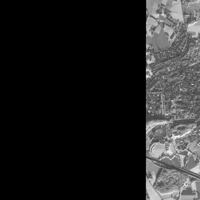
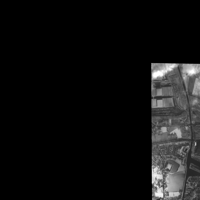
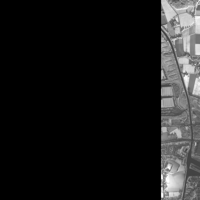
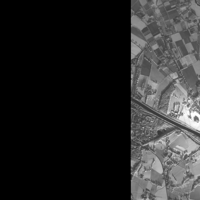
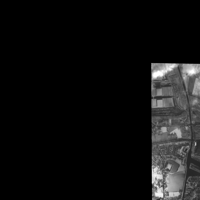
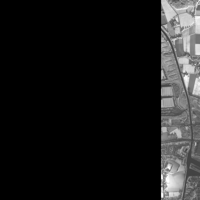
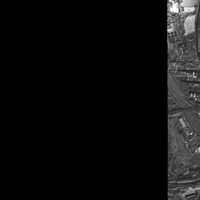
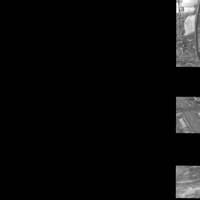
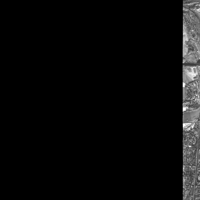
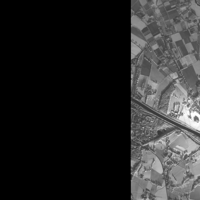
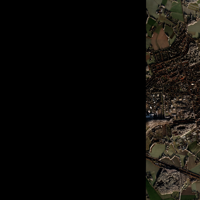
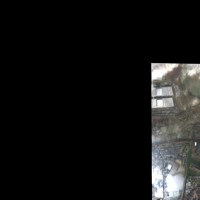
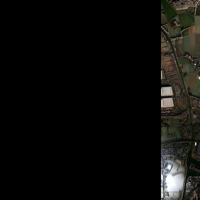
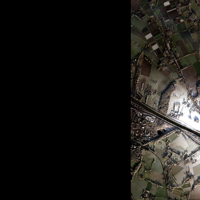
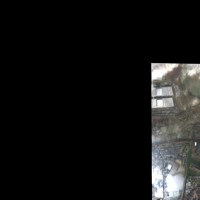
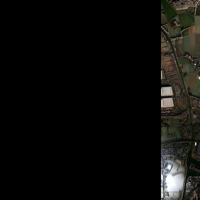
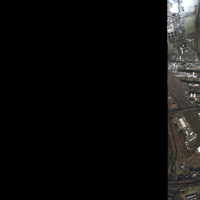
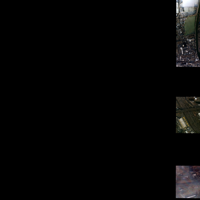
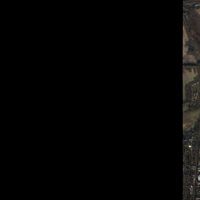
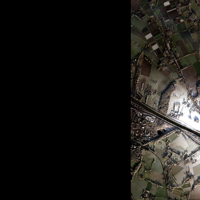
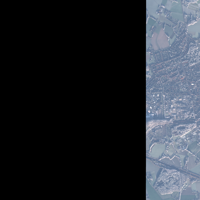
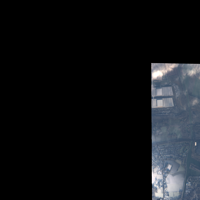
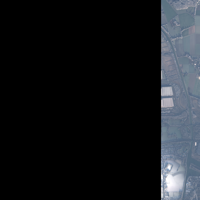
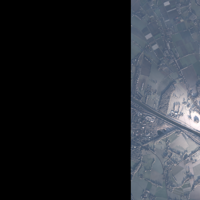
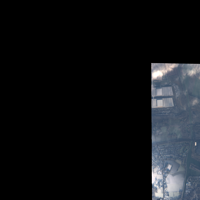
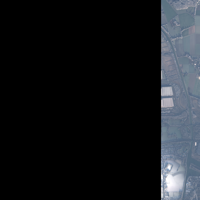
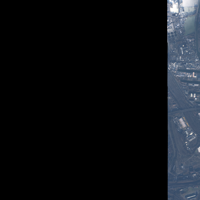
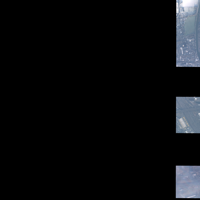
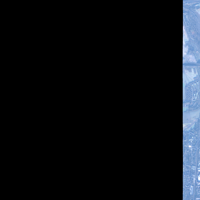
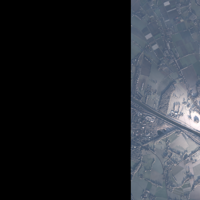


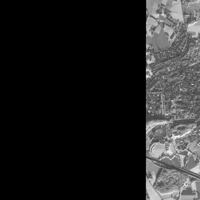
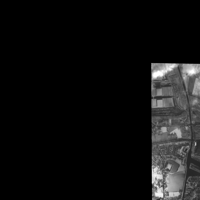
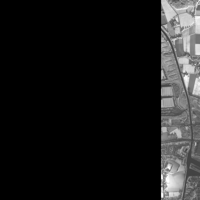
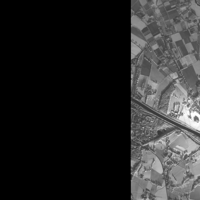
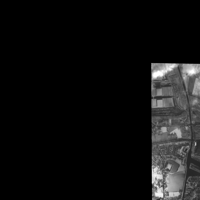
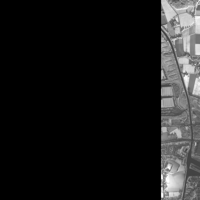
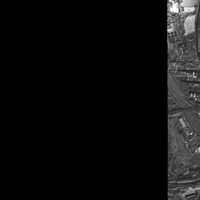
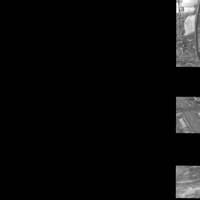
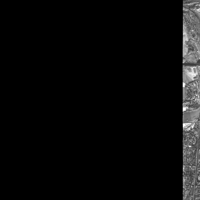
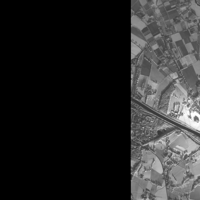
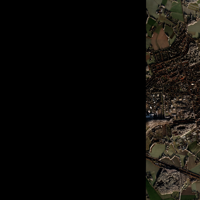
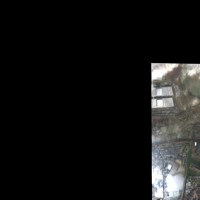
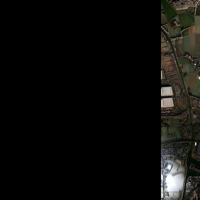
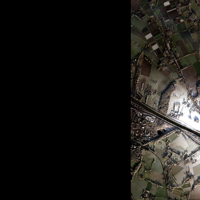
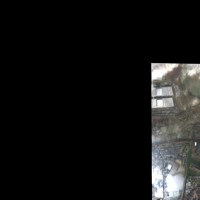
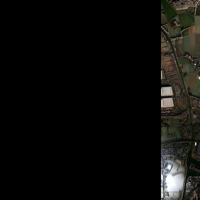
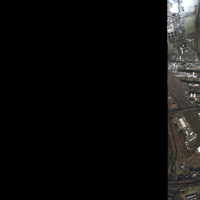
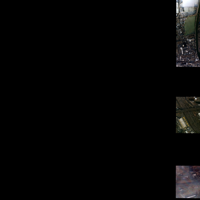
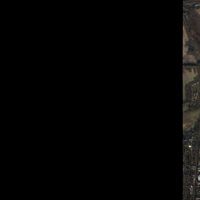
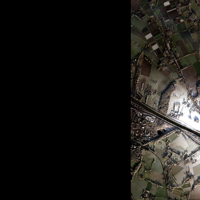
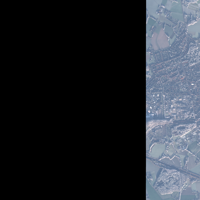
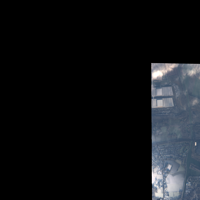
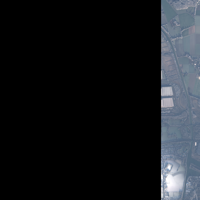
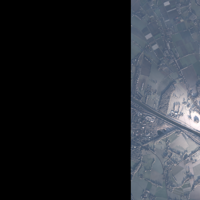
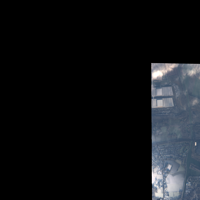
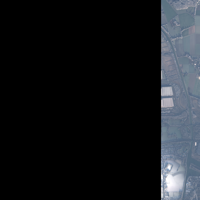
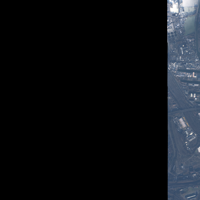
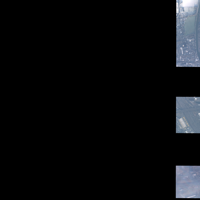
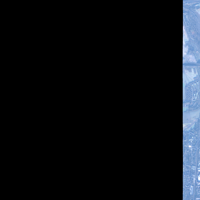
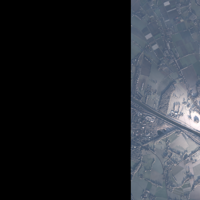

In [8]:
ipyplot.plot_class_tabs(images=images, labels=labels, img_width=200, max_imgs_per_tab=10)



In [ ]:
sentinel_dir = Path("/mnt/data/unsupervised_dataset/test_all_works/sentinel_2/")

sentinel_images = []
sentinel_labels = []
for sample_dir in gen_samples(sentinel_dir, max_samples=100):
    band_dict = {}
    for band_path in sample_dir.glob("*.tif"):
        
        band_name = band_path.stem
        band_data, _ = load_band(band_path)
                
        if band_name == "SCL":
            band_data *= 20
        band_dict[band_name] = band_data[0]
    
    if len(band_dict) <= 10:
        print(f"skipping this directory {sample_dir}. Contains the following bands {', '.join(band_dict.keys())}.")
        continue
    
    with open(sample_dir / "metadata.json", 'r') as fd:
        sentinel_metadata = json.load(fd)

        
    keys = sorted(band_dict.keys())
    for key in keys:
        labels.append(key)
        band_img = float_image_to_uint8([band_dict[key]])[0]
        images.append(band_img)
        
    RGB_img = np.stack([band_dict[key] for key in ("B04", "B03", "B02")], axis=2)
    RGB_img = float_image_to_uint8([RGB_img])[0]
    sentinel_images.append(RGB_img)
    sentinel_labels.append("RGB")



skipping this directory /mnt/data/unsupervised_dataset/test_all_works/sentinel_2/zip_6/51_59N7_41E/2019-04-15. Contains the following bands B01.
skipping this directory /mnt/data/unsupervised_dataset/test_all_works/sentinel_2/zip_6/51_67N7_36E/2019-04-15. Contains the following bands B01.
skipping this directory /mnt/data/unsupervised_dataset/test_all_works/sentinel_2/zip_6/51_44N7_01E/2019-04-15. Contains the following bands B01.
skipping this directory /mnt/data/unsupervised_dataset/test_all_works/sentinel_2/zip_6/51_56N7_41E/2019-04-15. Contains the following bands B01.
skipping this directory /mnt/data/unsupervised_dataset/test_all_works/sentinel_2/zip_6/51_63N7_42E/2019-04-15. Contains the following bands B01.
skipping this directory /mnt/data/unsupervised_dataset/test_all_works/sentinel_2/zip_3/51_56N7_41E/2019-04-15. Contains the following bands B01.
skipping this directory /mnt/data/unsupervised_dataset/test_all_works/sentinel_2/zip_3/51_53N7_41E/2019-04-15. Contains the follow


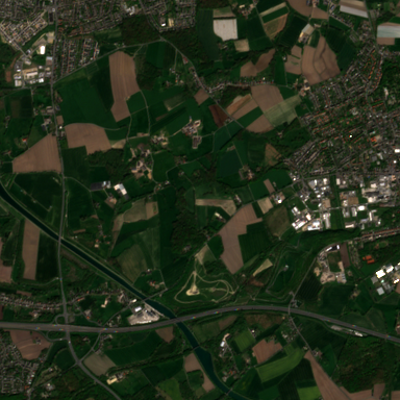
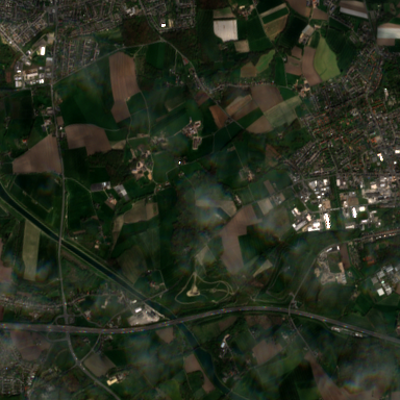
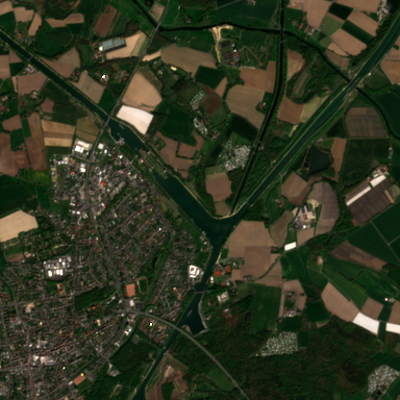
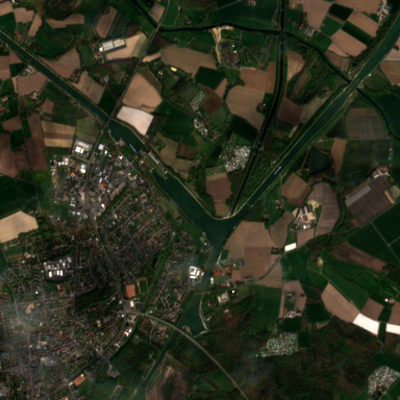
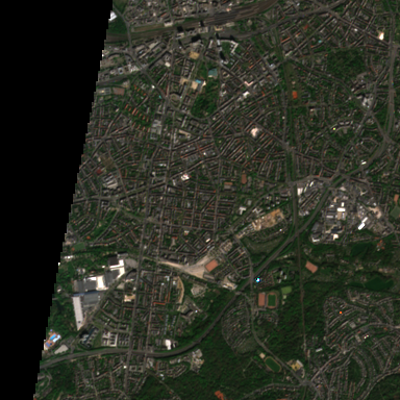
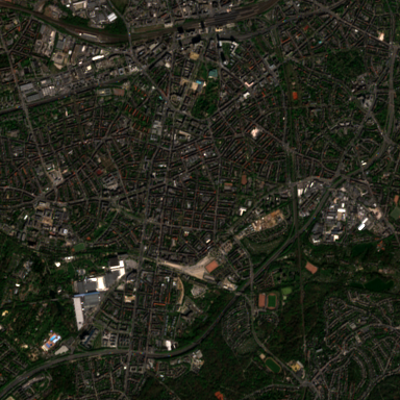
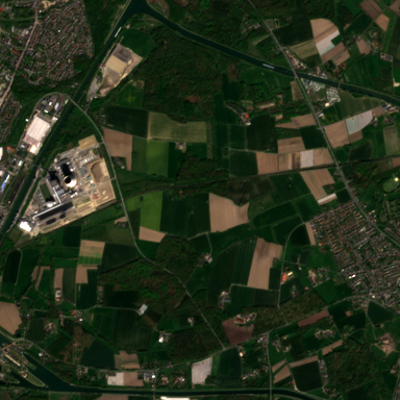


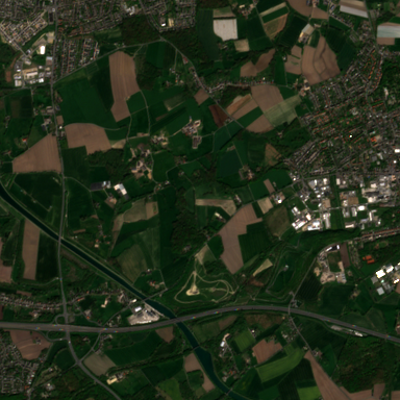
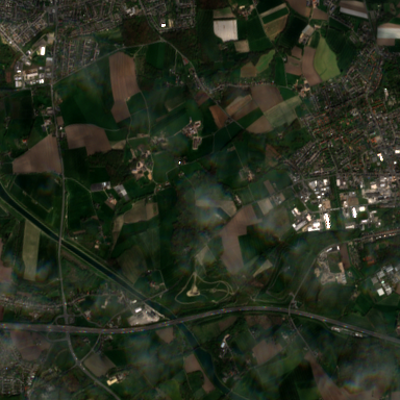
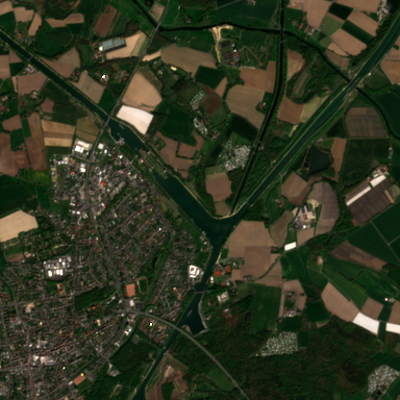
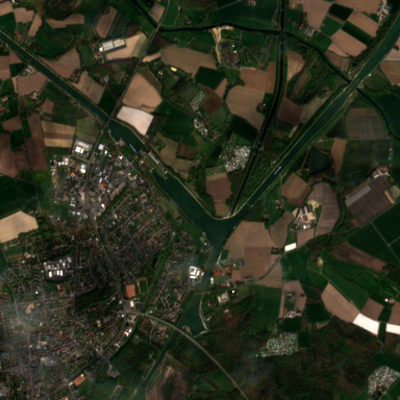
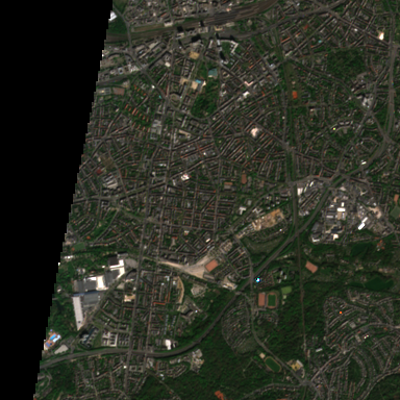
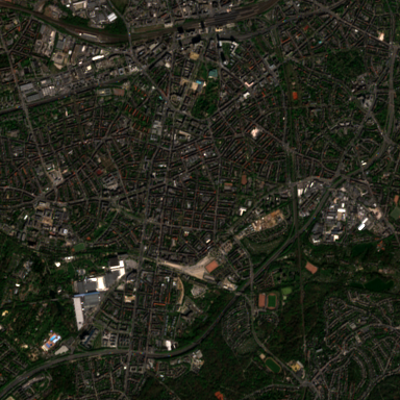
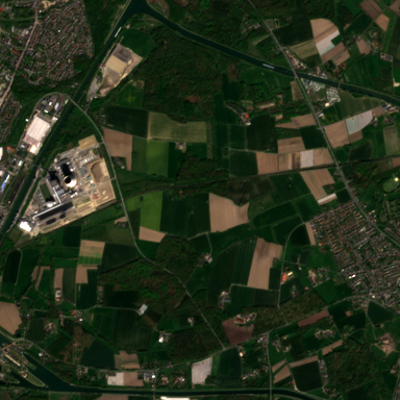

In [20]:
ipyplot.plot_class_tabs(images=sentinel_images, labels=sentinel_labels, img_width=200, max_imgs_per_tab=40)


In [ ]:
satellogic_metadata

In [ ]:
sentinel_metadata

In [12]:
from pathlib import Path
list(Path("/mnt/data/unsupervised_dataset/test_all_works/satellogic/zip_1").rglob("*"))

[PosixPath('/mnt/data/unsupervised_dataset/test_all_works/satellogic/zip_1/51_63N7_42E'),
 PosixPath('/mnt/data/unsupervised_dataset/test_all_works/satellogic/zip_1/51_59N7_41E'),
 PosixPath('/mnt/data/unsupervised_dataset/test_all_works/satellogic/zip_1/51_63N7_42E/2021-12-22'),
 PosixPath('/mnt/data/unsupervised_dataset/test_all_works/satellogic/zip_1/51_63N7_42E/2021-12-22/RGB_enhanced.jpg'),
 PosixPath('/mnt/data/unsupervised_dataset/test_all_works/satellogic/zip_1/51_63N7_42E/2021-12-22/red.tif'),
 PosixPath('/mnt/data/unsupervised_dataset/test_all_works/satellogic/zip_1/51_63N7_42E/2021-12-22/green.tif'),
 PosixPath('/mnt/data/unsupervised_dataset/test_all_works/satellogic/zip_1/51_63N7_42E/2021-12-22/blue.tif'),
 PosixPath('/mnt/data/unsupervised_dataset/test_all_works/satellogic/zip_1/51_63N7_42E/2021-12-22/nir.tif'),
 PosixPath('/mnt/data/unsupervised_dataset/test_all_works/satellogic/zip_1/51_63N7_42E/2021-12-22/metadata.json'),
 PosixPath('/mnt/data/unsupervised_dataset/test